In [ ]:
!pip install --upgrade transformers huggingface_hub
!pip install transformers

In [4]:
from transformers import pipeline, set_seed, AutoTokenizer,AutoModel,TFAutoModel
from transformers import AutoModelForSequenceClassification
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import torch
import torch.nn.functional as F
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
set_seed(42)

In [5]:
text = """Dear Amazon, last week I ordered an Optimus Prime action figure \
from your online store in Germany. Unfortunately, when I opened the package, \
I discovered to my horror that I had been sent an action figure of Megatron \
instead! As a lifelong enemy of the Decepticons, I hope you can understand my \
dilemma. To resolve the issue, I demand an exchange of Megatron for the \
Optimus Prime figure I ordered. Enclosed are copies of my records concerning \
this purchase. I expect to hear from you soon. Sincerely, Bumblebee."""

In [ ]:
all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

In [3]:
from datasets import load_dataset
emotion = load_dataset("ag_news")

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [8]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [9]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [10]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [11]:
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


In [12]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,True,False,False
1,False,False,True
2,False,True,False


In [13]:
input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

In [14]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [15]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


In [6]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [16]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [17]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)
print(tokenizer.convert_tokens_to_string(tokens))

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']
[CLS] tokenizing text is a core task of nlp. [SEP]


In [18]:
print(tokenizer.vocab_size)
print(tokenizer.model_max_length)
print(tokenizer.model_input_names)

30522
512
['input_ids', 'attention_mask']


In [19]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)
print(tokenize(emotion["train"][:2]))

{'input_ids': [[101, 2813, 2358, 1012, 6468, 15020, 2067, 2046, 1996, 2304, 1006, 26665, 1007, 26665, 1011, 2460, 1011, 19041, 1010, 2813, 2395, 1005, 1055, 1040, 11101, 2989, 1032, 2316, 1997, 11087, 1011, 22330, 8713, 2015, 1010, 2024, 3773, 2665, 2153, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 18431, 2571, 3504, 2646, 3293, 13395, 1006, 26665, 1007, 26665, 1011, 2797, 5211, 3813, 18431, 2571, 2177, 1010, 1032, 2029, 2038, 1037, 5891, 2005, 2437, 2092, 1011, 22313, 1998, 5681, 1032, 6801, 3248, 1999, 1996, 3639, 3068, 1010, 2038, 5168, 2872, 1032, 2049, 29475, 2006, 2178, 2112, 1997, 1996, 3006, 1012, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [20]:
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


Using Pipeline

In [ ]:
classifier=pipeline('text-classification')
output=classifier(text)
pd.DataFrame(output)

ner_tagger = pipeline("ner", aggregation_strategy="simple")
outputs = ner_tagger(text)
pd.DataFrame(outputs)

,label,score
0,NEGATIVE,0.901545


In [ ]:
summarizer = pipeline("summarization")
outputs = summarizer(text, max_length=45, clean_up_tokenization_spaces=True)
print(outputs[0]['summary_text'])

reader = pipeline("question-answering")
question = "What does the customer want?"
outputs = reader(question=question, context=text)
pd.DataFrame([outputs])

In [ ]:
translator = pipeline("translation_en_to_de", )
outputs = translator(text, clean_up_tokenization_spaces=True, min_length=100)
print(outputs[0]['translation_text'])

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Dear Amazon, last week I ordered an Optimus Prime action figure from your online
store in Germany. Unfortunately, when I opened the package, I discovered to my
horror that I had been sent an action figure of Megatron instead!As a lifelong
enemy of the Decepticons, I hope you can understand my dilemma.To resolve the
issue, I demand an exchange of Megatron for the Optimus Prime figure I ordered.
Enclosed are copies of my records concerning this purchase. I expect to hear
from you soon. Sincerely


In [ ]:
generator = pipeline("text-generation")
response = "Dear Bumblebee, I am sorry to hear that your order was mixed up."
prompt = text + "\n\nCustomer service response:\n" + response
outputs = generator(prompt, max_length=200)
print(outputs[0]['generated_text'])

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Dear Amazon, last week I ordered an Optimus Prime action figure from your online
store in Germany. Unfortunately, when I opened the package, I discovered to my
horror that I had been sent an action figure of Megatron instead! As a lifelong
enemy of the Decepticons, I hope you can understand my dilemma. To resolve the
issue, I demand an exchange of Megatron for the Optimus Prime figure I ordered.
Enclosed are copies of my records concerning this purchase. I expect to hear
from you soon. Sincerely, Bumblebee.

Customer service response:
Dear Bumblebee, I am sorry to hear that your order was mixed up. I found that I
needed to purchase a new version of the Optimus Prime action figure from your
online store. I appreciate your continued support. The price I paid for an
Optimus Prime action figure also did not qualify for a full return policy.
However, we will be sure to make sure you will receive a corrected product and a
refund. I


Continue

In [ ]:
emotion

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [ ]:
train_ds = emotion["train"]
train_ds, len(train_ds)

(Dataset({
     features: ['text', 'label'],
     num_rows: 120000
 }),
 120000)

In [ ]:
print(train_ds[0])
print(train_ds.column_names)
print(train_ds.features)

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters -
Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green
again.", 'label': 2}
['text', 'label']
{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=4,
names=['World', 'Sports', 'Business', 'Sci/Tech'], names_file=None, id=None)}


In [ ]:
print(train_ds[:5])

{'text': ["Wall St. Bears Claw Back Into the Black (Reuters) Reuters -
Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green
again.", 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private
investment firm Carlyle Group,\\which has a reputation for making well-timed and
occasionally\\controversial plays in the defense industry, has quietly
placed\\its bets on another part of the market.', "Oil and Economy Cloud Stocks'
Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy
and the outlook for earnings are expected to\\hang over the stock market next
week during the depth of the\\summer doldrums.", 'Iraq Halts Oil Exports from
Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil
export\\flows from the main pipeline in southern Iraq after\\intelligence showed
a rebel militia could strike\\infrastructure, an oil official said on
Saturday.', 'Oil prices soar to all-time record, posing new menace to US econo

In [ ]:
print(train_ds["text"][:5])

["Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers,
Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private
investment firm Carlyle Group,\\which has a reputation for making well-timed and
occasionally\\controversial plays in the defense industry, has quietly
placed\\its bets on another part of the market.', "Oil and Economy Cloud Stocks'
Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy
and the outlook for earnings are expected to\\hang over the stock market next
week during the depth of the\\summer doldrums.", 'Iraq Halts Oil Exports from
Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil
export\\flows from the main pipeline in southern Iraq after\\intelligence showed
a rebel militia could strike\\infrastructure, an oil official said on
Saturday.', 'Oil prices soar to all-time record, posing new menace to US economy
(AFP) 

In [ ]:
emotion.set_format(type="pandas")
df = emotion["train"][:]
df.head()

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [ ]:
def label_int2str(row):
    return emotion["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,Wall St. Bears Claw Back Into the Black (Reute...,2,Business
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,Business
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,Business
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,Business
4,"Oil prices soar to all-time record, posing new...",2,Business


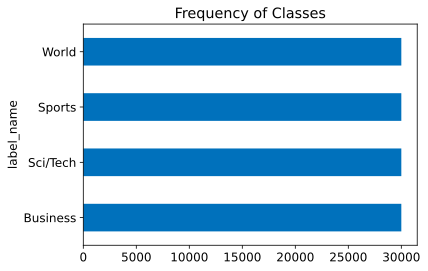

In [ ]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

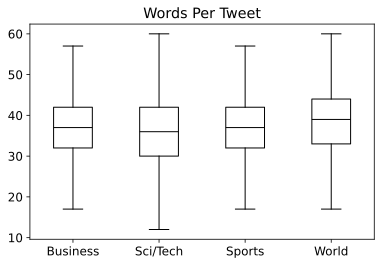

In [ ]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [ ]:
emotion.reset_format()

In [21]:
emotions_encoded = emotion.map(tokenize, batched=True, batch_size=None)
print(emotions_encoded["train"].column_names)

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask']


In [ ]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [22]:
from transformers import AutoModel
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
from transformers import TFAutoModel
tf_xlmr = TFAutoModel.from_pretrained("xlm-roberta-base", from_pt=True)
tf_model = TFAutoModel.from_pretrained(model_ckpt)

In [24]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [25]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [27]:
print(outputs.last_hidden_state.size())
print(outputs.last_hidden_state[:,0].size())

torch.Size([1, 6, 768])
torch.Size([1, 768])


In [28]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [29]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

In [ ]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

In [ ]:
emotions_hidden["train"].column_names

In [ ]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

In [ ]:
X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotion["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

In [38]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [ ]:
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

In [36]:
# hide_output
from transformers import AutoModelForSequenceClassification

num_labels = 4
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [40]:
from huggingface_hub import notebook_login

notebook_login()

In [43]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["test"],
                  tokenizer=tokenizer)
trainer.train();

/tmp/ipython-input-1155130480.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: abhishek-chavan22 (abhishek-chavan22-pccoe) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss


In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [ ]:
preds_output.metrics

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [ ]:
plot_confusion_matrix(y_preds, y_valid, labels)

In [ ]:
from transformers import TFAutoModelForSequenceClassification

tf_model = (TFAutoModelForSequenceClassification
            .from_pretrained(model_ckpt, num_labels=num_labels))

In [ ]:
tokenizer_columns = tokenizer.model_input_names

tf_train_dataset = emotions_encoded["train"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=True,
    batch_size=batch_size)
tf_eval_dataset = emotions_encoded["validation"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=False,
    batch_size=batch_size)

In [ ]:
tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy())

tf_model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=2)

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [ ]:
#hide_output
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

In [ ]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)